In [127]:
from epftoolbox.models import evaluate_lear_in_test_dataset, evaluate_dnn_in_test_dataset, hyperparameter_optimizer
from epftoolbox.data import read_data
from epftoolbox.evaluation import sMAPE, rMAE, GW, plot_multivariate_GW_test, plot_multivariate_DM_test
import pandas as pd
from matplotlib import pyplot as plt
import os

countries = ['AT', 'BE', 'CZ', 'DE_LU', 'FR', 'HR', 'HU', 'NL', 'PL', 'RO', 'SI', 'SK']

start_date_io = pd.Timestamp('20230201')
end_date_io = pd.Timestamp('20230728')
#end_date_io = pd.Timestamp('20230301')

start_date_test = pd.Timestamp('20230201')
end_date_test = pd.Timestamp('20230430')
end_date_test_io = pd.Timestamp('20230501')

df_observed = pd.read_excel("../data-july/day_ahead_prices.xlsx", index_col=0)
io_forecast = pd.read_excel('../price_forecasts/price_forecast_until_july_2_february-july.xlsx')

#df_observed = pd.read_excel("../data/day_ahead_prices.xlsx", index_col=0)
#io_forecast = pd.read_excel('../price_forecasts/price_forecast_full_alpha5_norm_1_w_atc_february.xlsx')

df_observed = df_observed.loc[(df_observed.index >= start_date_io) & (df_observed.index < end_date_io)]
io_forecast.index = df_observed.index

In [128]:
start_date_show = pd.Timestamp('20230201')
end_date_show = pd.Timestamp('20230228')

AT

LEAR - sMAPE: 14.15%
DNN - sMAPE: 14.74%
IO - sMAPE: 16.08%


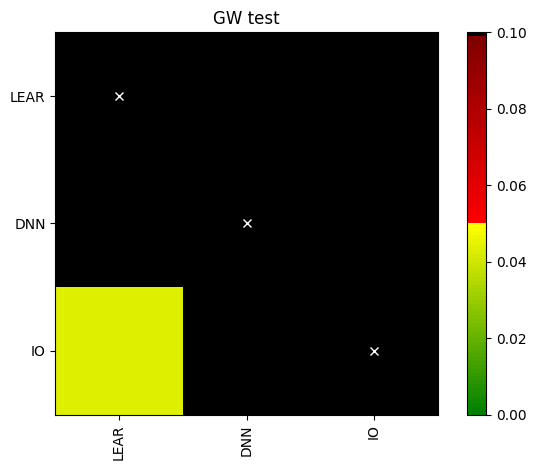

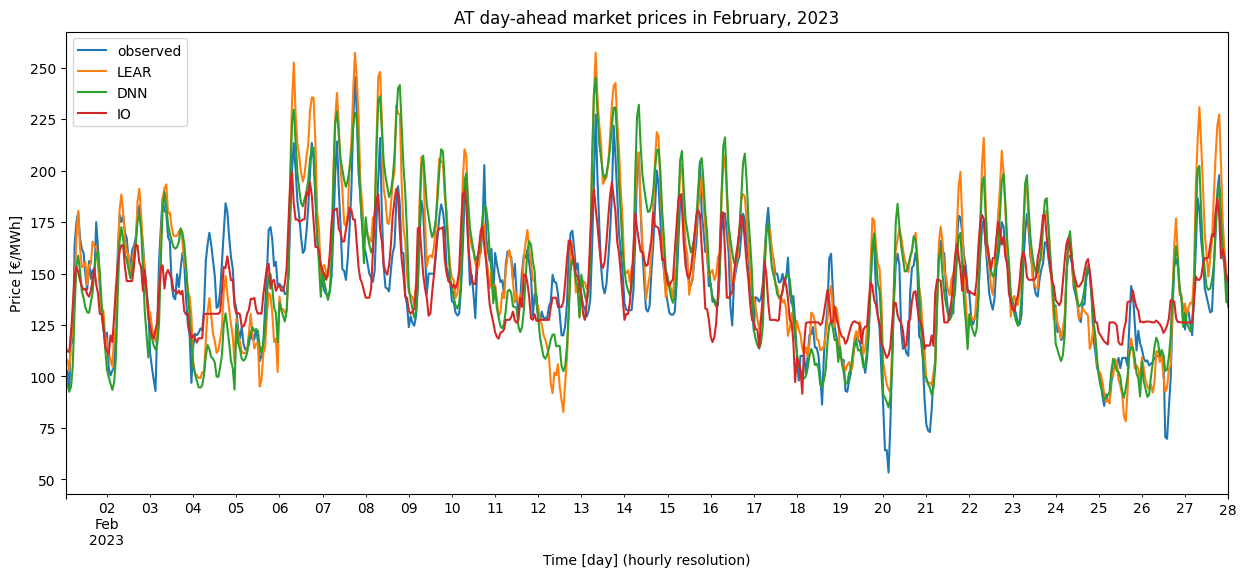

BE

LEAR - sMAPE: 17.91%
DNN - sMAPE: 17.35%
IO - sMAPE: 20.42%


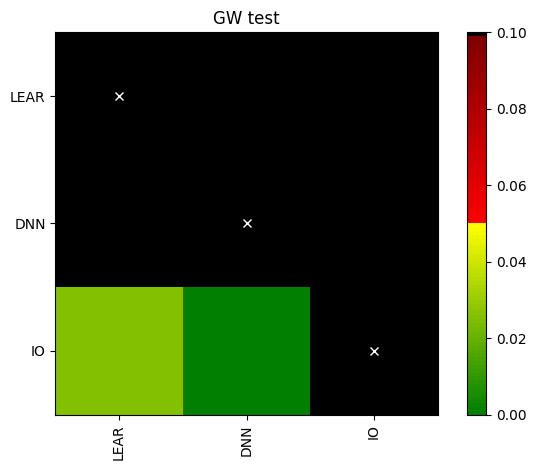

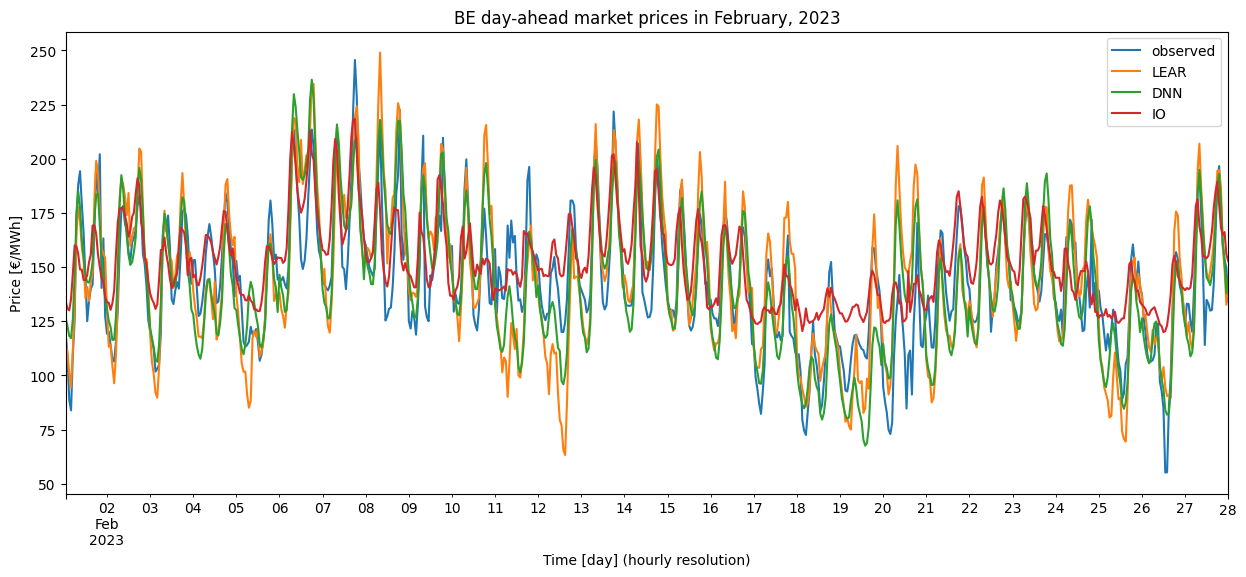

CZ

LEAR - sMAPE: 19.17%
DNN - sMAPE: 17.45%
IO - sMAPE: 18.29%


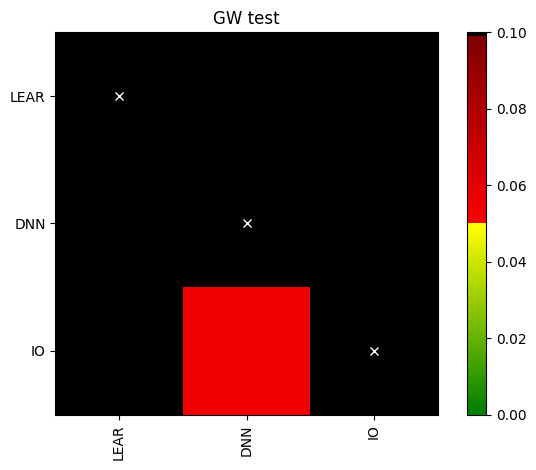

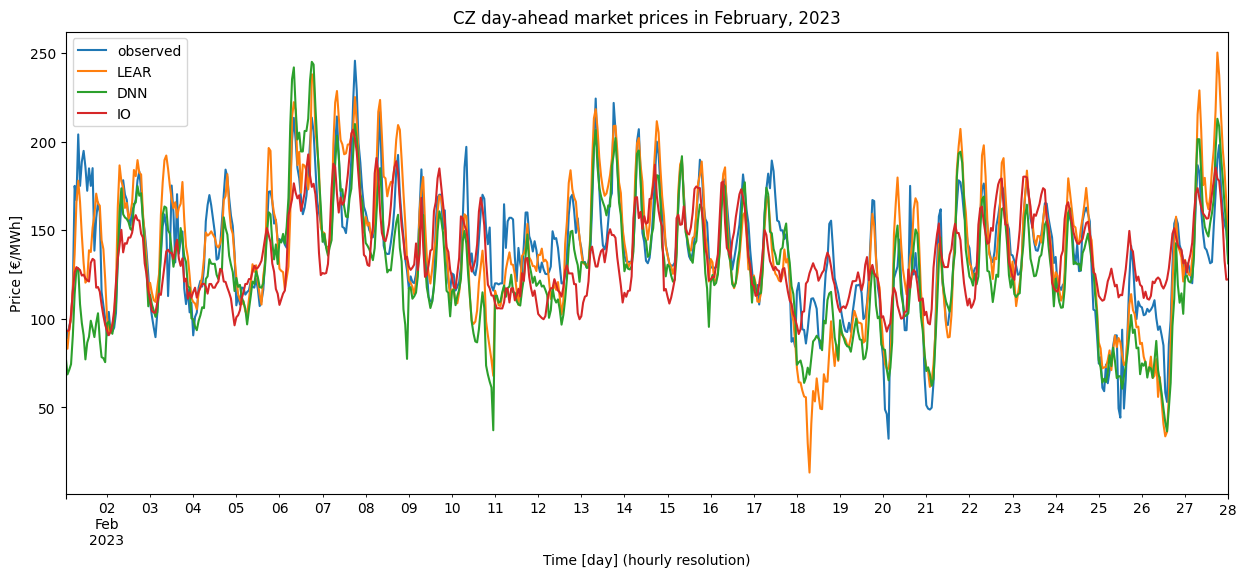

DE_LU

LEAR - sMAPE: 21.73%
DNN - sMAPE: 18.81%
IO - sMAPE: 24.61%


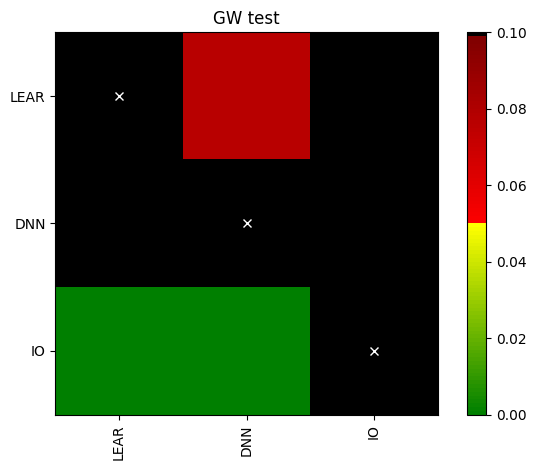

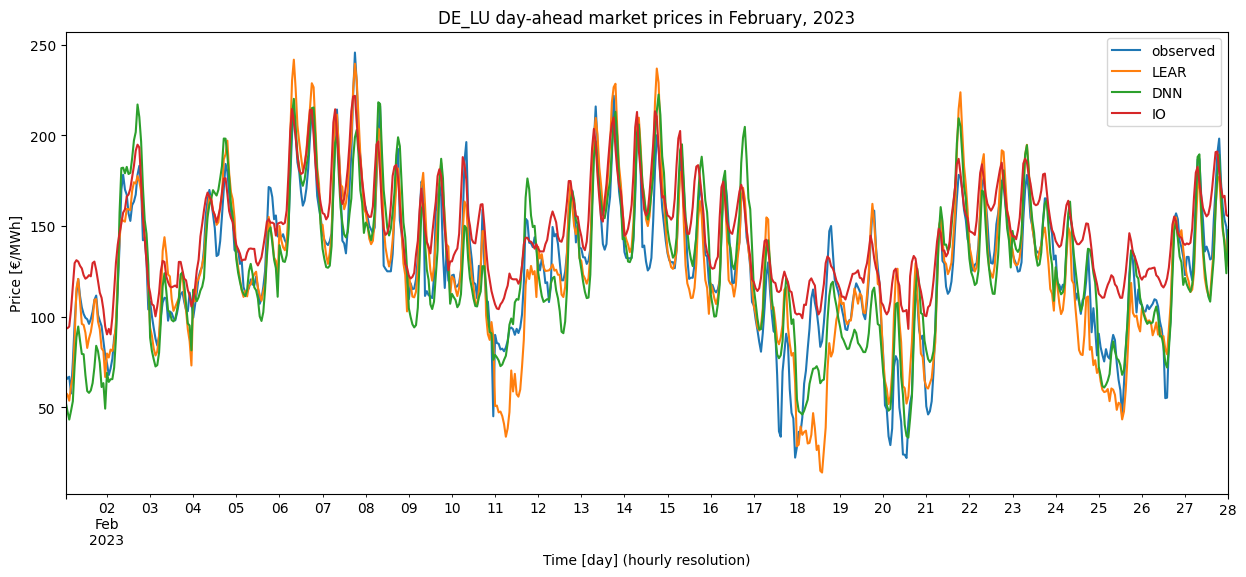

FR

LEAR - sMAPE: 17.19%
DNN - sMAPE: 15.10%
IO - sMAPE: 20.47%


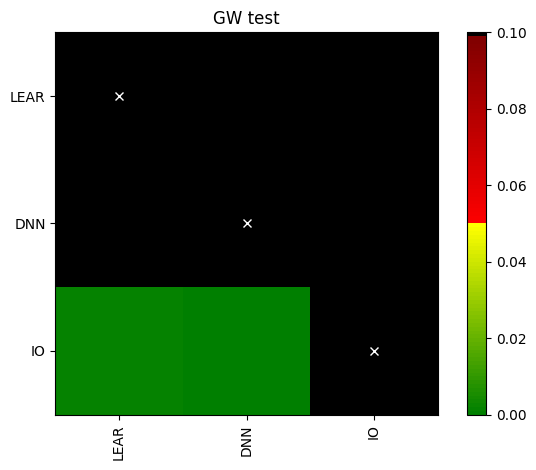

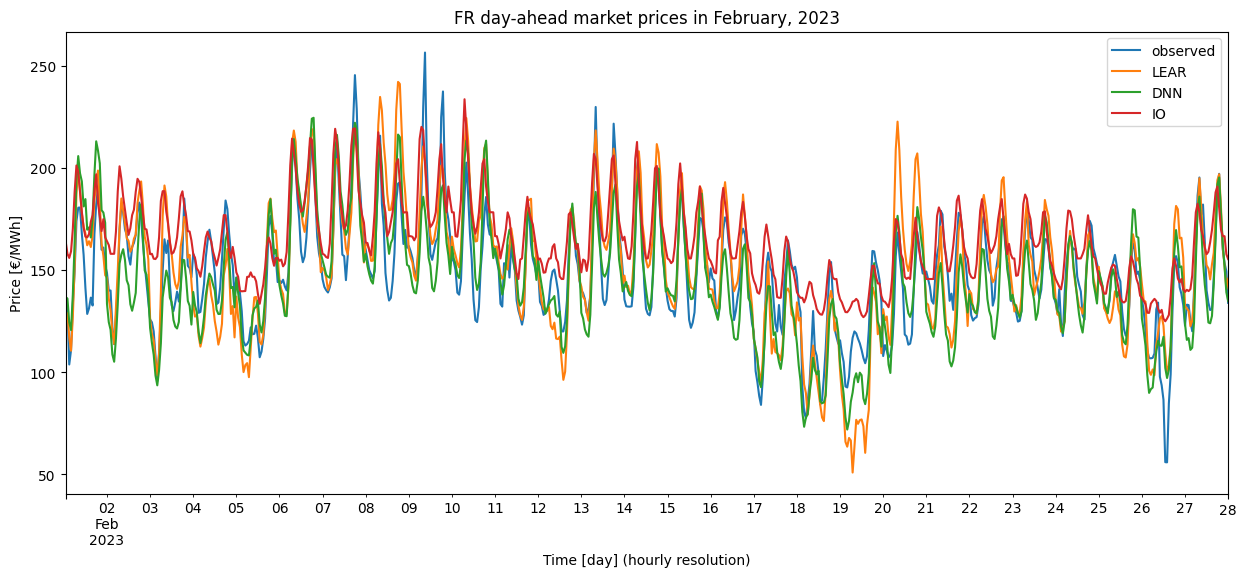

HR

LEAR - sMAPE: 17.24%
DNN - sMAPE: 16.37%
IO - sMAPE: 17.32%


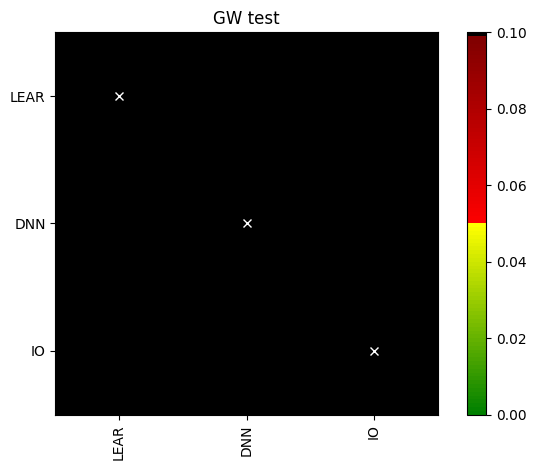

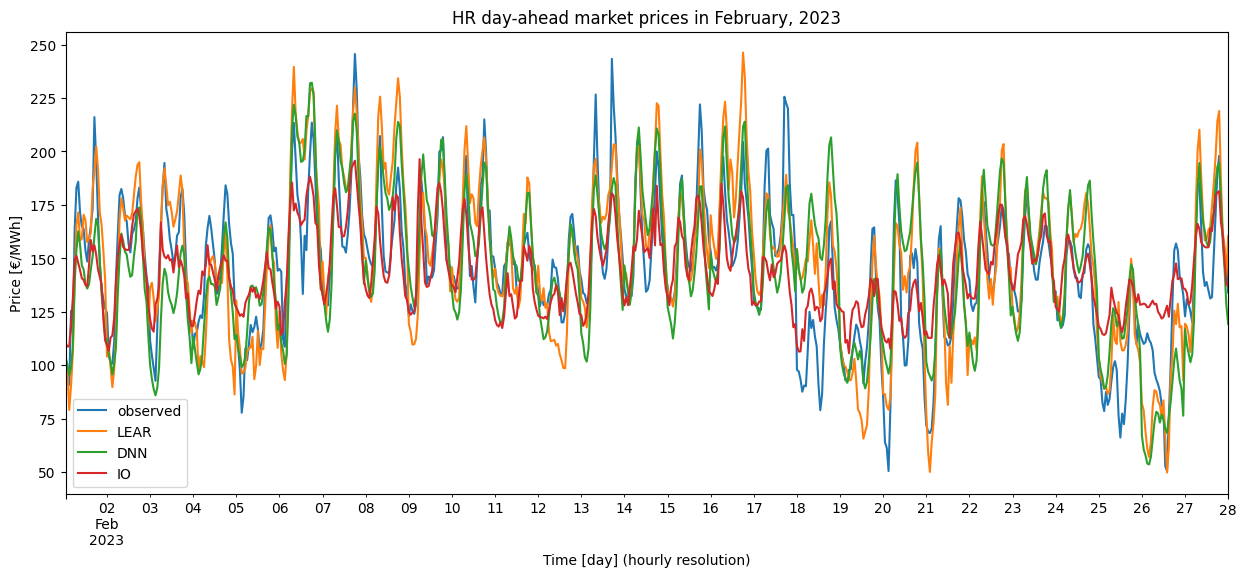

HU

LEAR - sMAPE: 17.63%
DNN - sMAPE: 16.85%
IO - sMAPE: 17.70%


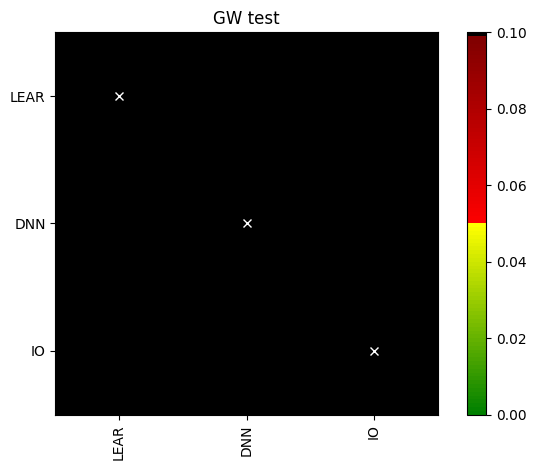

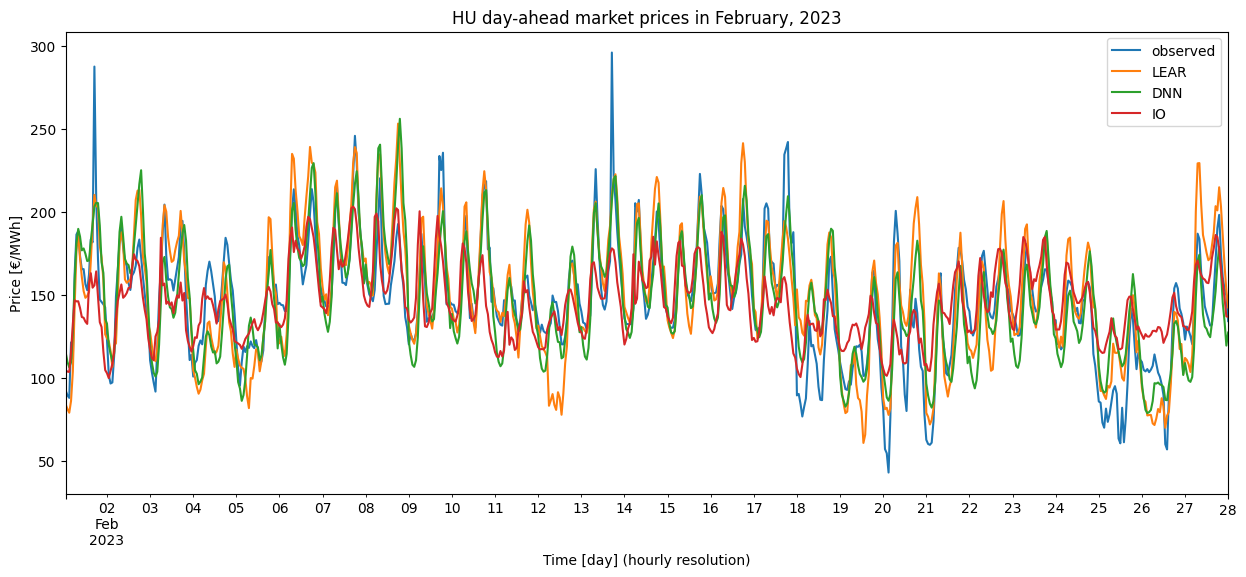

NL

LEAR - sMAPE: 23.42%
DNN - sMAPE: 22.36%
IO - sMAPE: 21.70%


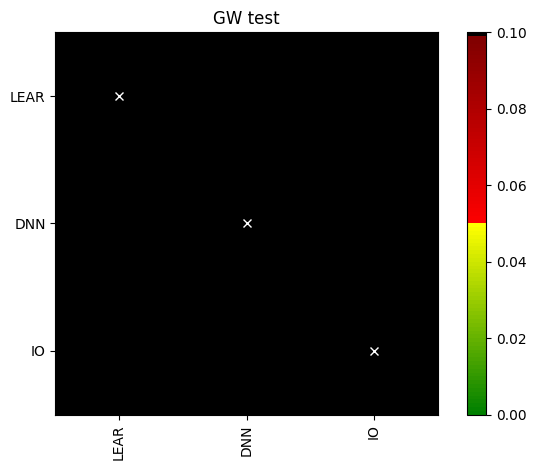

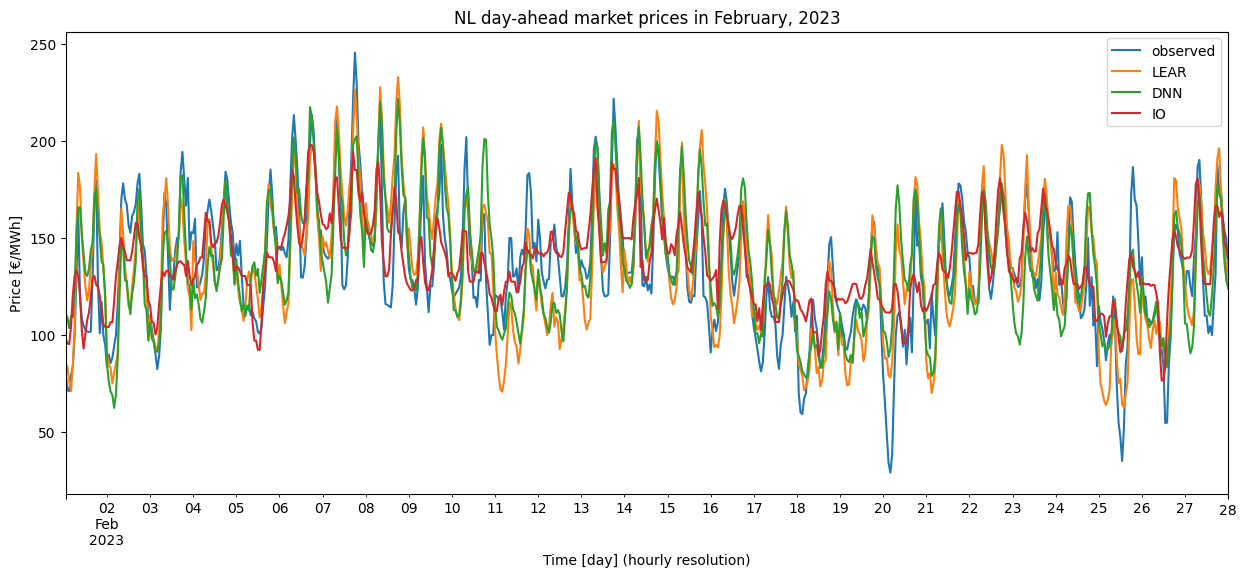

PL

LEAR - sMAPE: 10.29%
DNN - sMAPE: 11.41%
IO - sMAPE: 11.03%


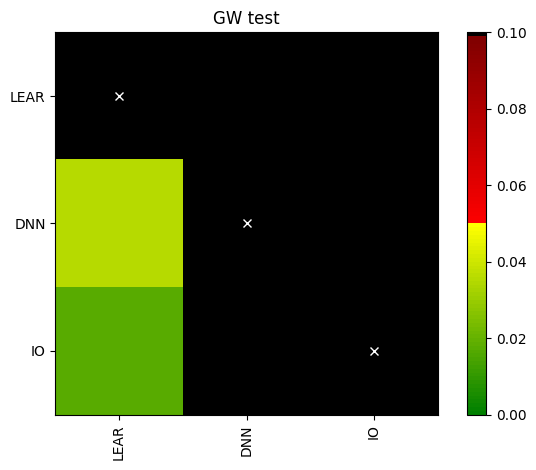

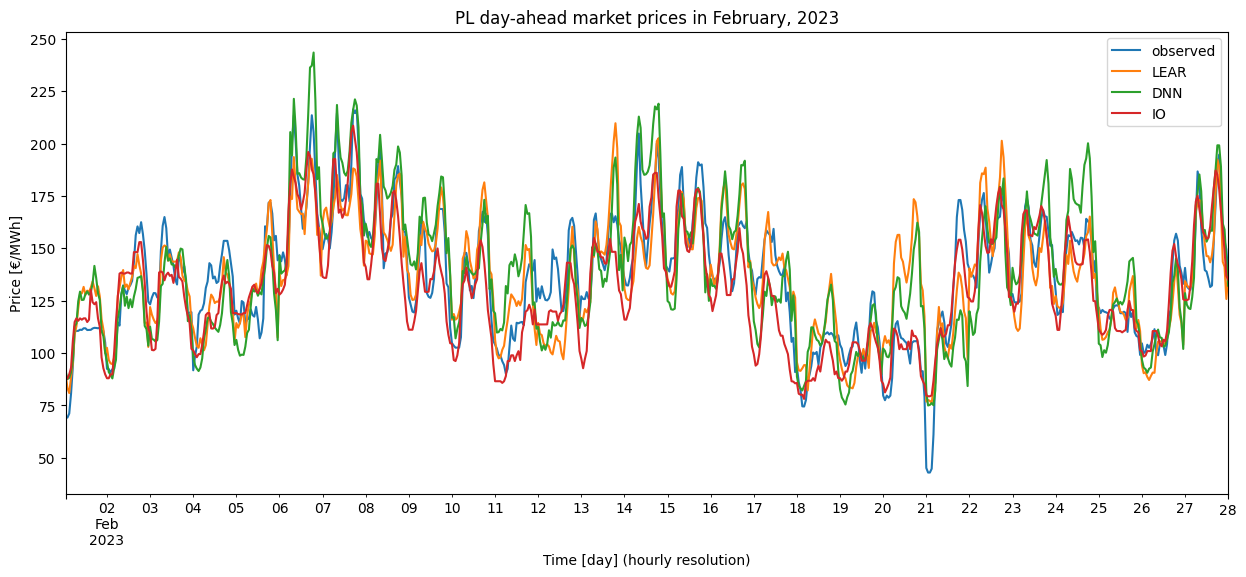

RO

LEAR - sMAPE: 30.52%
DNN - sMAPE: 26.97%
IO - sMAPE: 35.00%


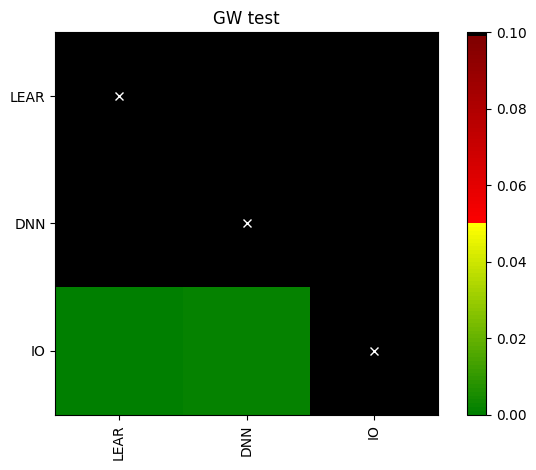

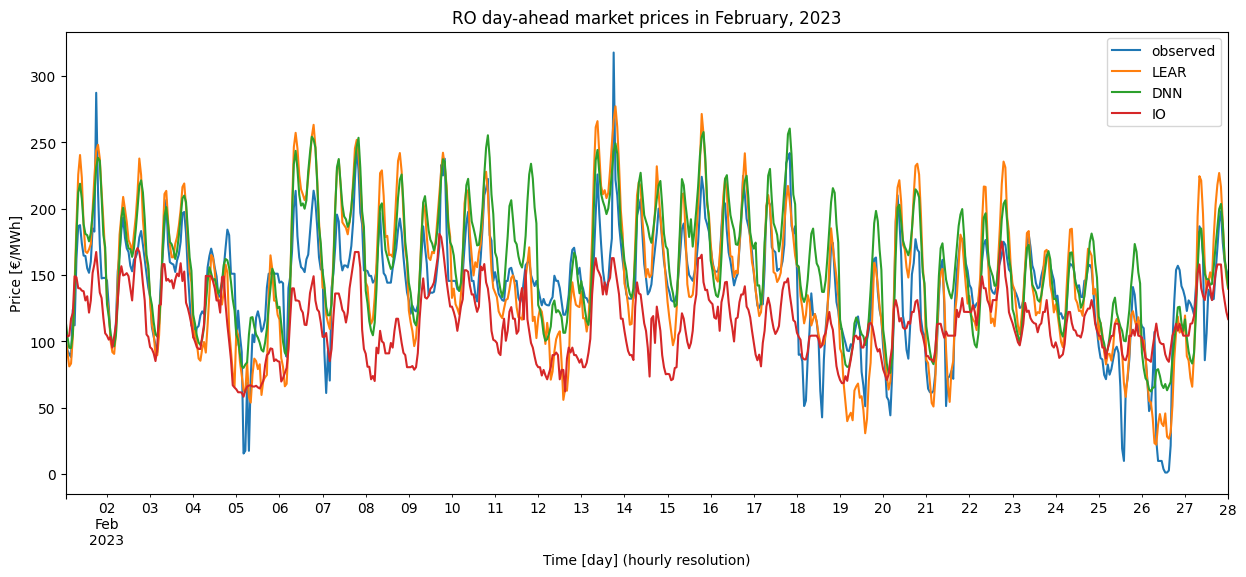

SI

LEAR - sMAPE: 14.90%
DNN - sMAPE: 16.00%
IO - sMAPE: 16.67%


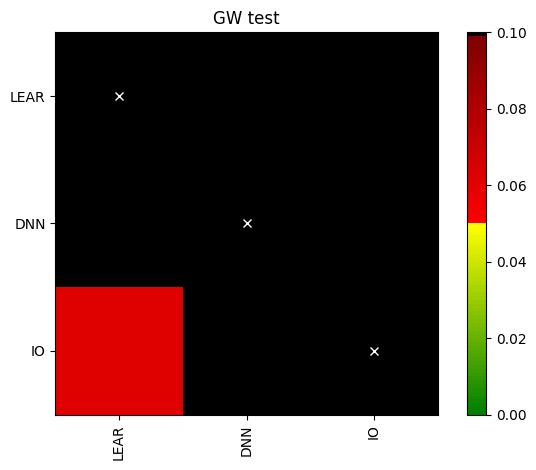

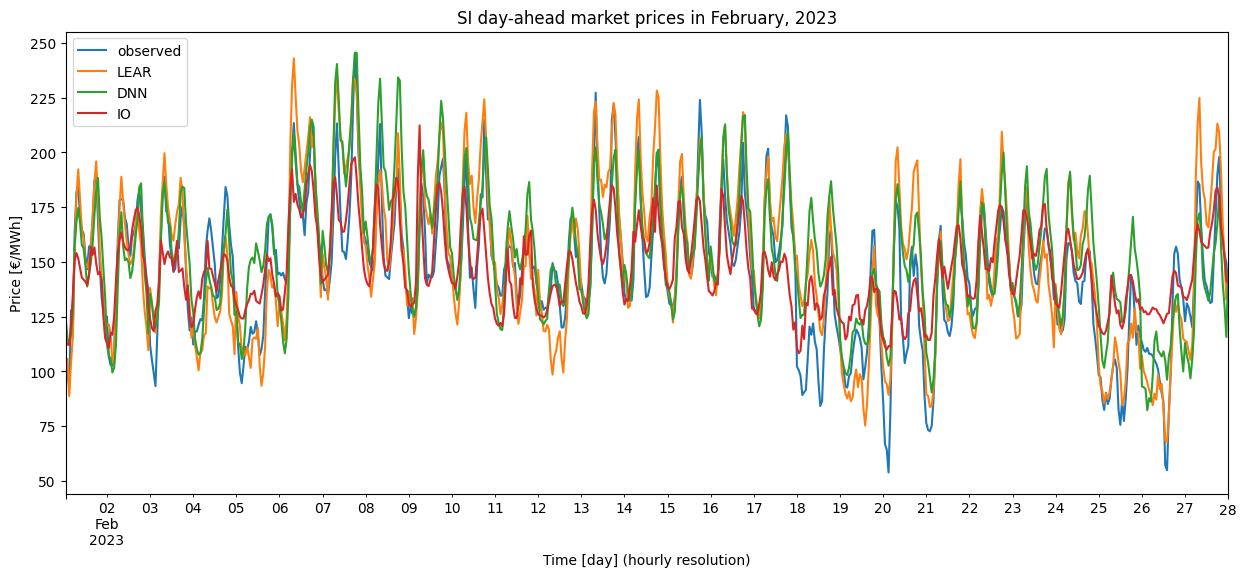

SK

LEAR - sMAPE: 16.44%
DNN - sMAPE: 16.06%
IO - sMAPE: 17.88%


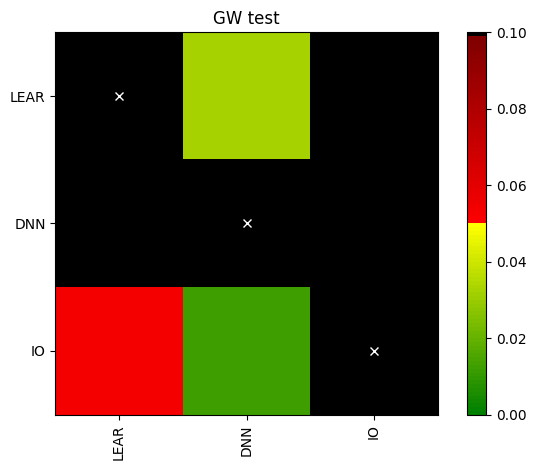

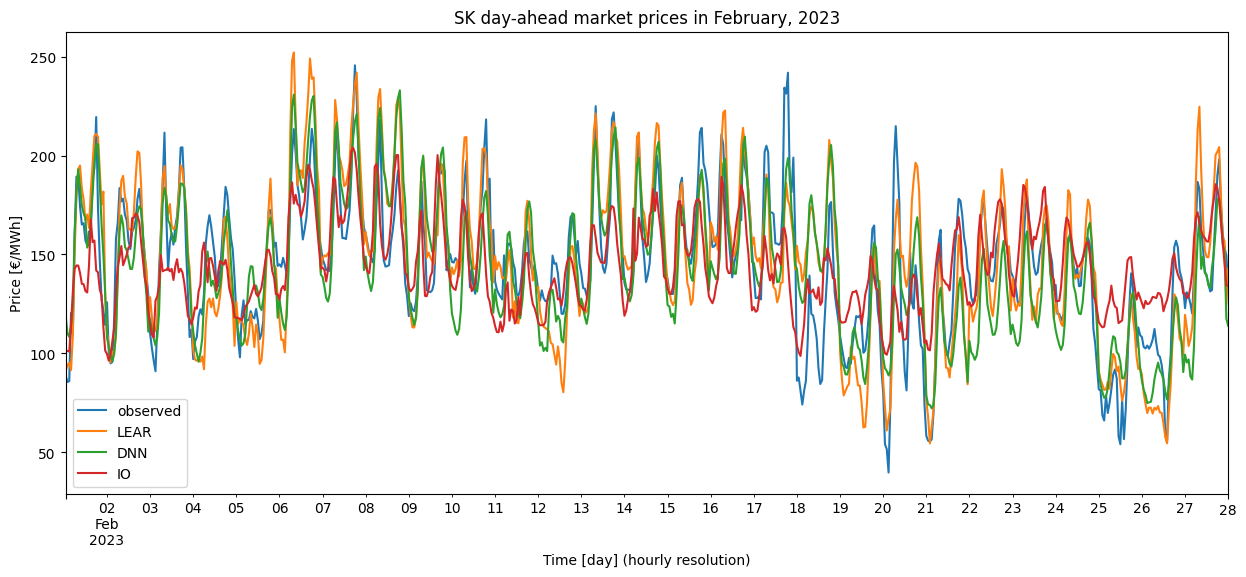

In [129]:
for zone in countries:
    print(zone)
    
    forecasts = pd.DataFrame()
    
    lear_dataset = pd.read_csv('./experimental_files/LEAR_forecast_dat{0}_CORE_YT2_CW728.csv'.format(zone), index_col=0)
    dnn_dataset = pd.read_csv('./experimental_files/DNN_forecast_nl2_dat{0}_CORE_YT2_SFH1_CW2_1.csv'.format(zone), index_col=0)
    
    lear_dataset.index = pd.to_datetime(lear_dataset.index)
    dnn_dataset.index = pd.to_datetime(dnn_dataset.index)
    
    lear_dataset = lear_dataset.loc[(lear_dataset.index >= start_date_test) & (lear_dataset.index <= end_date_test)]
    dnn_dataset = dnn_dataset.loc[(dnn_dataset.index >= start_date_test) & (dnn_dataset.index <= end_date_test)]
    
    for index, row in lear_dataset.iterrows():
        for h in range(24):
            forecasts.loc[index + pd.DateOffset(hours=h), 'LEAR'] = row['h{0}'.format(h)]
    
    for index, row in dnn_dataset.iterrows():
        for h in range(24):
            forecasts.loc[index + pd.DateOffset(hours=h), 'DNN'] = row['h{0}'.format(h)]
    
    forecasts['IO'] = io_forecast.loc[(io_forecast.index >= start_date_test) & (io_forecast.index <= end_date_test_io)].iloc[0:-1][zone]
    
    real_price = df_observed.loc[(df_observed.index >= start_date_test) & (df_observed.index < end_date_test_io), [zone]]

    forecasts['real_price'] = real_price
    
    forecasts_indexes = forecasts[(forecasts.LEAR != 0) & (forecasts.DNN != 0) & (forecasts.IO != 0)].index
    forecasts = forecasts.loc[forecasts_indexes]

    del forecasts['real_price']
    real_price = real_price.loc[forecasts_indexes]

    print('')
    print('LEAR - sMAPE: {:.2f}%'.format(100*sMAPE(p_pred=forecasts.LEAR, p_real=real_price[zone])))
    print('DNN - sMAPE: {:.2f}%'.format(100*sMAPE(p_pred=forecasts.DNN, p_real=real_price[zone])))
    print('IO - sMAPE: {:.2f}%'.format(100*sMAPE(p_pred=forecasts.IO, p_real=real_price[zone])))
    plot_multivariate_GW_test(real_price=real_price, forecasts=forecasts)

    plt.figure(figsize=(15,6))
    
    ax = real_price.loc[(real_price.index > start_date_show) & (real_price.index <= end_date_show)][zone].plot()
    forecasts.loc[(forecasts.index > start_date_show) & (forecasts.index <= end_date_show)].LEAR.plot(ax=ax)
    forecasts.loc[(forecasts.index > start_date_show) & (forecasts.index <= end_date_show)].DNN.plot(ax=ax)
    forecasts.loc[(forecasts.index > start_date_show) & (forecasts.index <= end_date_show)].IO.plot(ax=ax)
    
    plt.title("{0} day-ahead market prices in February, 2023".format(zone))
    plt.ylabel('Price [€/MWh]')
    plt.xlabel('Time [day] (hourly resolution)')
    ax.legend(['observed', 'LEAR', 'DNN', 'IO'])
    plt.show()